### *`import libraries `*

In [1]:
pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=73789fcecbdecba9ba04ee6c70ccdaffaf0fdd15e97e86c54593dbb33186575a
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [2]:
import math
import time
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pyDOE import lhs

In [3]:
DATA_PATH_B = '/content/drive/MyDrive/DL/PINN/B.csv'
DATA_PATH_Bx = '/content/drive/MyDrive/DL/PINN/Bx.csv'
DATA_PATH_By = '/content/drive/MyDrive/DL/PINN/By.csv'
DATA_PATH_xq = '/content/drive/MyDrive/DL/PINN/xq.csv'
DATA_PATH_yq = '/content/drive/MyDrive/DL/PINN/yq.csv'

### *`visualize input`*

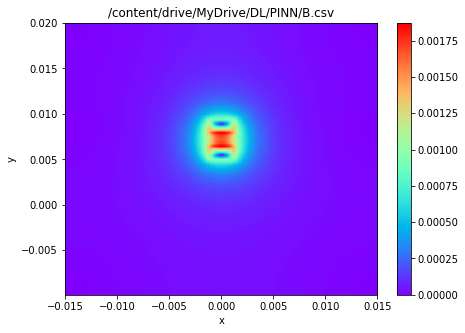

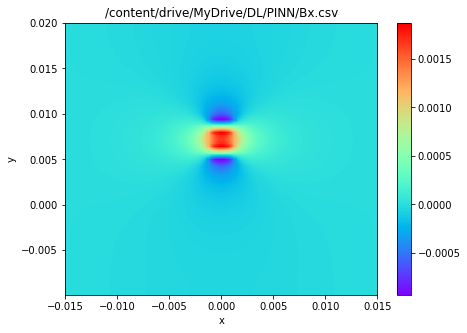

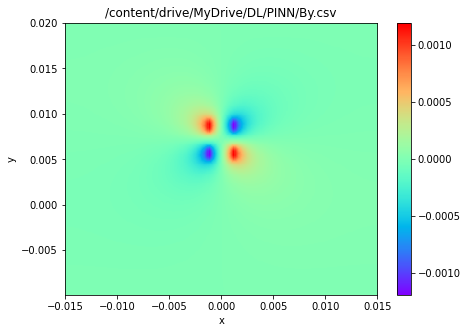

In [4]:
def visualize_dataset(dataset):
    xq = pd.read_csv(DATA_PATH_xq)
    xq = xq.to_numpy()
    yq = pd.read_csv(DATA_PATH_yq)
    yq = yq.to_numpy()

    data = pd.read_csv(dataset)
    data = data.to_numpy()

    plt.figure(figsize = (7,5))
    fig = plt.imshow(data, cmap = 'rainbow', interpolation = 'nearest', extent = [xq.min(), xq.max(), yq.min(), yq.max()], origin = 'lower', aspect = 'auto')
    plt.colorbar(fig)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(dataset)
    plt.show()

visualize_dataset(DATA_PATH_B)
visualize_dataset(DATA_PATH_Bx)
visualize_dataset(DATA_PATH_By)

### *`create dataset`*

In [5]:
NUM_POINTS = 1000
NUM_PER_BOUND_POINTS = 200
NUM_BOUND_POINTS = 4 * NUM_PER_BOUND_POINTS
BATCH_SIZE = 32
NUM_BATCHES = math.ceil(NUM_POINTS*BATCH_SIZE/NUM_BOUND_POINTS)

LOW_BOUND_1 = tf.constant([-0.01, -0.015], dtype=tf.float32)
UP_BOUND_1 = tf.constant([0.02, 0.015], dtype=tf.float32)

# Build input for PDE loss 1
F_train_1 = LOW_BOUND_1 + (UP_BOUND_1 - LOW_BOUND_1) * lhs(2, NUM_POINTS)

LOW_BOUND_2 = tf.constant([0.008, -0.0012], dtype=tf.float32)
UP_BOUND_2 = tf.constant([0.0094, 0.0012], dtype=tf.float32)

# Build input for PDE loss 2
F_train_2 = LOW_BOUND_2 + (UP_BOUND_2 - LOW_BOUND_2) * lhs(2, NUM_POINTS)

LOW_BOUND_3 = tf.constant([0.005, -0.0012], dtype=tf.float32)
UP_BOUND_3 = tf.constant([0.0064, 0.0012], dtype=tf.float32)

# Build input for PDE loss 3
F_train_3 = LOW_BOUND_3 + (UP_BOUND_3 - LOW_BOUND_3) * lhs(2, NUM_POINTS)

def random_uniform(num_points, low_bound = 0., up_bound = 1., **kwargs):
    data = tf.random.uniform([num_points, 1], minval = low_bound, maxval = up_bound)
    return data

# lower u(x, -0.01) & upper u(x, 0.02) boundary of sub domain 1
yxl_1 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.015, up_bound=0.015)
yxl_1 = tf.concat([yxl_1, tf.ones_like(yxl_1)*-0.01], axis=1)
yxu_1 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.015, up_bound=0.015)
yxu_1 = tf.concat([yxu_1, tf.ones_like(yxu_1)*0.02], axis=1)

# Left u(-0.015, y) & right u(0.015, y) boundary of sub domain 1
xyl_1 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.01, up_bound=0.02)
xyl_1 = tf.concat([tf.ones_like(xyl_1)*-0.015, xyl_1], axis=1)
xyr_1 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.01, up_bound=0.02)
xyr_1 = tf.concat([tf.ones_like(xyr_1)*0.015, xyr_1], axis=1)

# Dataset for sub domain 1 (u(x, y)) = 0
bound_train_1 = tf.concat([xyl_1, yxl_1, xyr_1, yxu_1], axis=0)
u_bound_per = tf.zeros([NUM_PER_BOUND_POINTS, 1], dtype=tf.float32)
bound_train_truth_1 = tf.concat([u_bound_per, u_bound_per, u_bound_per, u_bound_per], axis=0)

# lower u(x, 0.008) & upper u(x, 0.0094) boundary of sub domain 2
yxl_2 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.0012, up_bound=0.0012)
yxl_2 = tf.concat([yxl_2, tf.ones_like(yxl_2)*0.008], axis=1)
yxu_2 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.0012, up_bound=0.0012)
yxu_2 = tf.concat([yxu_2, tf.ones_like(yxu_2)*0.0094], axis=1)

# Left u(-0.0012, y) & right u(0.0012, y) boundary of sub domain 2
xyl_2 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=0.008, up_bound=0.0094)
xyl_2 = tf.concat([tf.ones_like(xyl_2)*-0.0012, xyl_2], axis=1)
xyr_2 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=0.008, up_bound=0.0094)
xyr_2 = tf.concat([tf.ones_like(xyr_2)*0.0012, xyr_2], axis=1)

# Dataset for sub domain 2 (u(x, y))
bound_train_2 = tf.concat([xyl_2, yxl_2, xyr_2, yxu_2], axis=0)

# lower u(x, 0.005) & upper u(x, 0.0064) boundary of sub domain 3
yxl_3 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.0012, up_bound=0.0012)
yxl_3 = tf.concat([yxl_3, tf.ones_like(yxl_3)*0.005], axis=1)
yxu_3 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=-0.0012, up_bound=0.0012)
yxu_3 = tf.concat([yxu_3, tf.ones_like(yxu_3)*0.0064], axis=1)

# Left u(-0.0012, y) & right u(0.0012, y) boundary of sub domain 3
xyl_3 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=0.005, up_bound=0.0064)
xyl_3 = tf.concat([tf.ones_like(xyl_3)*-0.0012, xyl_3], axis=1)
xyr_3 = random_uniform(NUM_PER_BOUND_POINTS, low_bound=0.005, up_bound=0.0064)
xyr_3 = tf.concat([tf.ones_like(xyr_3)*0.0012, xyr_3], axis=1)

# Dataset for sub domain 3 (u(x, y))
bound_train_3 = tf.concat([xyl_3, yxl_3, xyr_3, yxu_3], axis=0)

In [6]:
U_dataset_1 = tf.data.Dataset.from_tensor_slices((bound_train_1, bound_train_truth_1))
U_dataset_1 = U_dataset_1.shuffle(buffer_size=100).batch(BATCH_SIZE)
U_dataset_2 = tf.data.Dataset.from_tensor_slices(bound_train_2)
U_dataset_2 = U_dataset_2.shuffle(buffer_size=100).batch(BATCH_SIZE)
U_dataset_3 = tf.data.Dataset.from_tensor_slices(bound_train_3)
U_dataset_3 = U_dataset_3.shuffle(buffer_size=100).batch(BATCH_SIZE)

f_batch_size = np.floor(F_train_1.shape[0] / (bound_train_1.shape[0] / BATCH_SIZE))

F_dataset_1 = tf.data.Dataset.from_tensor_slices(F_train_1)
F_dataset_1 = F_dataset_1.shuffle(buffer_size=10000).batch(f_batch_size)
F_dataset_2 = tf.data.Dataset.from_tensor_slices(F_train_2)
F_dataset_2 = F_dataset_2.shuffle(buffer_size=10000).batch(f_batch_size)
F_dataset_3 = tf.data.Dataset.from_tensor_slices(F_train_3)
F_dataset_3 = F_dataset_3.shuffle(buffer_size=10000).batch(f_batch_size)

### ***`build model`***

### *`sub domain 1 - the air`*

In [14]:
initializers = tf.keras.initializers.GlorotUniform()

# Define the model
inputs = tf.keras.layers.Input(shape=(2,), dtype=tf.float32)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(inputs)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
outputs = tf.keras.layers.Dense(1, kernel_initializer=initializers)(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_18 (Dense)            (None, 30)                90        
                                                                 
 dense_19 (Dense)            (None, 30)                930       
                                                                 
 dense_20 (Dense)            (None, 30)                930       
                                                                 
 dense_21 (Dense)            (None, 30)                930       
                                                                 
 dense_22 (Dense)            (None, 30)                930       
                                                                 
 dense_23 (Dense)            (None, 1)                 31  

### *`sub domain 2 - L1`*

In [15]:
initializers = tf.keras.initializers.GlorotUniform()

inputs = tf.keras.layers.Input(shape=(2,), dtype=tf.float32)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(inputs)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
outputs = tf.keras.layers.Dense(1, kernel_initializer=initializers)(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_24 (Dense)            (None, 30)                90        
                                                                 
 dense_25 (Dense)            (None, 30)                930       
                                                                 
 dense_26 (Dense)            (None, 30)                930       
                                                                 
 dense_27 (Dense)            (None, 30)                930       
                                                                 
 dense_28 (Dense)            (None, 30)                930       
                                                                 
 dense_29 (Dense)            (None, 1)                 31  

### *`sub domain 3 - L2`*

In [16]:
initializers = tf.keras.initializers.GlorotUniform()

# Define the model
inputs = tf.keras.layers.Input(shape=(2,), dtype=tf.float32)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(inputs)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=initializers)(x)
x = tf.keras.layers.Dense(330, activation='tanh', kernel_initializer=initializers)(x)
outputs = tf.keras.layers.Dense(1, kernel_initializer=initializers)(x)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_30 (Dense)            (None, 30)                90        
                                                                 
 dense_31 (Dense)            (None, 30)                930       
                                                                 
 dense_32 (Dense)            (None, 30)                930       
                                                                 
 dense_33 (Dense)            (None, 30)                930       
                                                                 
 dense_34 (Dense)            (None, 330)               10230     
                                                                 
 dense_35 (Dense)            (None, 1)                 331 

### ***`loss function`***

### *`pde - f1`*

In [17]:
@tf.function
def pde_fn_1(x, y):
    with tf.GradientTape(persistent=True)  as tape2:
        tape2.watch([x, y])
        with tf.GradientTape(persistent=True)  as tape1:
            tape1.watch([x, y])
            u = tf.squeeze(tf.cast(model_1(tf.stack([x, y],1), training=False), tf.float32))
        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)
        del tape1
    u_xx = tape2.gradient(u_x, x)
    u_yy = tape2.gradient(u_y, y)
    del tape2
    return u_xx + u_yy

### *`pde - f2`*

In [18]:
I = tf.constant(1.7, dtype=tf.float32) # Current density
J = (I/(math.pi*math.pow(0.001, 2/4)))

@tf.function
def pde_fn_2(x, y):
    with tf.GradientTape(persistent=True)  as tape2:
        tape2.watch([x, y])
        with tf.GradientTape(persistent=True)  as tape1:
            tape1.watch([x, y])
            u = tf.squeeze(tf.cast(model_2(tf.stack([x, y],1), training=False), tf.float32))
        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)
        del tape1
    u_xx = tape2.gradient(u_x, x)
    u_yy = tape2.gradient(u_y, y)
    del tape2
    return u_xx + u_yy - J

### *`pde - f3`*

In [19]:
@tf.function
def pde_fn_3(x, y):
    with tf.GradientTape(persistent=True)  as tape2:
        tape2.watch([x, y])
        with tf.GradientTape(persistent=True)  as tape1:
            tape1.watch([x, y])
            u = tf.squeeze(tf.cast(model_3(tf.stack([x, y],1), training=False), tf.float32))
        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)
        del tape1
    u_xx = tape2.gradient(u_x, x)
    u_yy = tape2.gradient(u_y, y)
    del tape2
    return u_xx + u_yy + J

### ***`training model `***

In [13]:
from keras.callbacks import EarlyStopping 
es = EarlyStopping(patience=3, restore_best_weights = True, monitor = 'val_accuracy', mode = 'max')

EPOCHS = 1000
BATCH_SIZE = 200

DEVICE = None
if tf.test.is_gpu_available():
    DEVICE = tf.test.gpu_device_name()
else:
    DEVICE = 'cpu'

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [21]:
# Define learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.95
)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the one step of training
@tf.function
def train_step(X_u_1, u_true, X_u_2, X_u_3, X_f_1, X_f_2, X_f_3):
    with tf.GradientTape() as tape:
        u_pred_1 = tf.cast(model_1(X_u_1), tf.float32)
        u_pred_2 = tf.cast(model_2(X_u_2), tf.float32)
        u_pred_3 = tf.cast(model_3(X_u_3), tf.float32)
        f_1 = pde_fn_1(X_f_1[:, 0], X_f_1[:, 1])
        f_2 = pde_fn_2(X_f_2[:, 0], X_f_2[:, 1])
        f_3 = pde_fn_3(X_f_3[:, 0], X_f_3[:, 1])
        loss = tf.losses.MeanSquaredError()(u_true, u_pred_1) \
                + tf.reduce_mean(tf.square(f_1)) \
                + tf.reduce_mean(tf.square(f_2)) \
                + tf.reduce_mean(tf.square(f_3)) \
                + tf.losses.MeanSquaredError()(u_pred_1, u_pred_2) \
                + tf.losses.MeanSquaredError()(u_pred_1, u_pred_3)
    grads = tape.gradient(loss, [model_1.trainable_variables \
                    ,model_2.trainable_variables, model_3.trainable_variables
                    ])
    optimizer.apply_gradients(zip(grads[0], model_1.trainable_variables))
    optimizer.apply_gradients(zip(grads[1], model_2.trainable_variables))
    optimizer.apply_gradients(zip(grads[2], model_3.trainable_variables))

    return loss

# Define the training loop
loss_history = []
start_time = time.time()

with tf.device(DEVICE):
    for epoch in range(EPOCHS):
        epoch_loss = []
        for step, ((X_u_1, u_true), X_u_2, X_u_3, X_f_1, X_f_2, X_f_3) in enumerate(zip(U_dataset_1, U_dataset_2, U_dataset_3, F_dataset_1, F_dataset_2, F_dataset_3)):
            loss = train_step(X_u_1, u_true, X_u_2, X_u_3, X_f_1, X_f_2, X_f_3)
            epoch_loss.append(loss)

        loss_history.append(np.mean(epoch_loss))
        if epoch % 100 == 0:
            end_time = time.time()
            print('Epoch: {}, Loss: {}, Time: {}'.format(epoch, loss_history[-1], end_time - start_time))
            start_time = time.time()

Epoch: 0, Loss: 366.1073913574219, Time: 6.163685321807861
Epoch: 100, Loss: 0.0020626967307180166, Time: 38.29468560218811
Epoch: 200, Loss: 0.0010627750307321548, Time: 21.58030867576599
Epoch: 300, Loss: 0.0006559450994245708, Time: 25.95394015312195
Epoch: 400, Loss: 0.0002749510749708861, Time: 30.692992210388184
Epoch: 500, Loss: 0.00017927026783581823, Time: 56.112173080444336
Epoch: 600, Loss: 0.0001797130680643022, Time: 24.532225131988525
Epoch: 700, Loss: 8.968057227320969e-05, Time: 36.10419797897339
Epoch: 800, Loss: 8.923783025238663e-05, Time: 24.54899764060974
Epoch: 900, Loss: 0.00012483347381930798, Time: 44.48570418357849


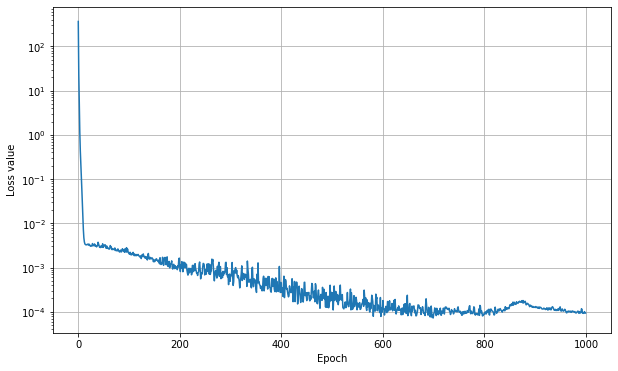

In [23]:
#%% Training loss
plt.figure(figsize=(10,6))
plt.semilogy(loss_history)

plt.grid()
plt.ylabel("Loss value")
plt.xlabel("Epoch")
plt.show()

### ***`result`***

### *`compare to the original data`*

In [24]:
def model_predict(X, Y):
    u = np.zeros(X.shape)
    for step, (a, b) in enumerate(zip(X, Y), 0):
        for col, (x, y) in enumerate(zip(a, b)):
            if (x > -0.0012) and (y > 0.008) and (x < 0.0012) and (y < 0.0094):
                u[step, col] = model_2(np.stack([x, y],1))
            elif (x > -0.0012) and (y > 0.005) and (x < 0.0012) and (y < 0.0064):
                u[step, col] = model_3(np.stack([x, y],1))
            else:
                u[step, col] = model_1(np.stack([x, y],1))
    return u